In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score
from livelossplot import PlotLosses
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device is {device}!")

Device is cpu!


In [2]:
df = pd.read_csv('./preprocessed.csv', low_memory=False) 
df

,dns_qtype,dns_rcode,dns_query,dst_ip_bytes,src_pkts,label,type,conn_state-OTH,conn_state-REJ,conn_state-RSTO,...,service-ssl,dns_AA--1,dns_AA-F,dns_AA-T,dns_RA--1,dns_RA-F,dns_RA-T,dns_RD--1,dns_RD-F,dns_RD-T
0,0,0,2,3786,6,0,normal,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,12,0,4765,172,1,0,normal,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,12,3,6112,800,1,0,normal,0,0,0,...,0,0,1,0,0,1,0,0,1,0
3,43,0,5259,525,1,0,normal,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,43,0,2790,408,1,0,normal,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46559,1,0,12284,158,1,0,normal,0,0,0,...,0,0,0,1,0,1,0,0,1,0
46560,0,0,2,8462,10,1,ddos,0,0,0,...,1,1,0,0,1,0,0,1,0,0
46561,12,0,3631,375,1,0,normal,0,0,0,...,0,0,1,0,0,1,0,0,1,0
46562,28,0,9338,712,1,0,normal,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [3]:
X = df.drop(['label','type'], axis=1)
X.head()

,dns_qtype,dns_rcode,dns_query,dst_ip_bytes,src_pkts,conn_state-OTH,conn_state-REJ,conn_state-RSTO,conn_state-RSTOS0,conn_state-RSTR,...,service-ssl,dns_AA--1,dns_AA-F,dns_AA-T,dns_RA--1,dns_RA-F,dns_RA-T,dns_RD--1,dns_RD-F,dns_RD-T
0,0,0,2,3786,6,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,12,0,4765,172,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,12,3,6112,800,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
3,43,0,5259,525,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,43,0,2790,408,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


### Binary Classfication

In [4]:
y = df.filter(items=['label'])
y.head()

,label
0,0
1,0
2,0
3,0
4,0


In [5]:
min_max_scaler = MinMaxScaler()
X =  pd.DataFrame(min_max_scaler.fit_transform(X))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.000000,0.0,0.000141,0.000044,0.000024,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.047059,0.0,0.336797,0.000002,0.000004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.047059,0.6,0.432005,0.000009,0.000004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.168627,0.0,0.371713,0.000006,0.000004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.168627,0.0,0.197201,0.000005,0.000004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [6]:
x = torch.Tensor(X.values) 
gt = torch.Tensor(y.values)

In [7]:
gt.size()

torch.Size([46564, 1])

In [8]:
x.size()

torch.Size([46564, 43])

In [9]:
# Create a TensorDataset from your data and labels
dataset = TensorDataset(x, gt)

# Calculate the number of samples for training and testing datasets
num_samples = len(dataset)
train_size = int(num_samples * 0.7)
test_size = num_samples - train_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

MLP

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(43, 128)
        self.b1 = nn.BatchNorm1d(128)
        self.l2 = nn.Linear(128, 16)
        self.b2 = nn.BatchNorm1d(16)
        self.l3 = nn.Linear(16, 64)
        self.b3 = nn.BatchNorm1d(64)
        self.last = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.b1(self.l1(x)))
        x = torch.relu(self.b2(self.l2(x)))
        x = torch.relu(self.b3(self.l3(x)))
        return torch.sigmoid(self.last(x))
    
net = MLP().to(device)
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(net.parameters()))}')

> Number of parameters 9265


In [11]:
opt = torch.optim.Adam(net.parameters(), lr=0.008430868939509882)

criterion = nn.BCELoss()

In [12]:
step = 0

liveloss = PlotLosses()

# logs for loss plots
logs = {}

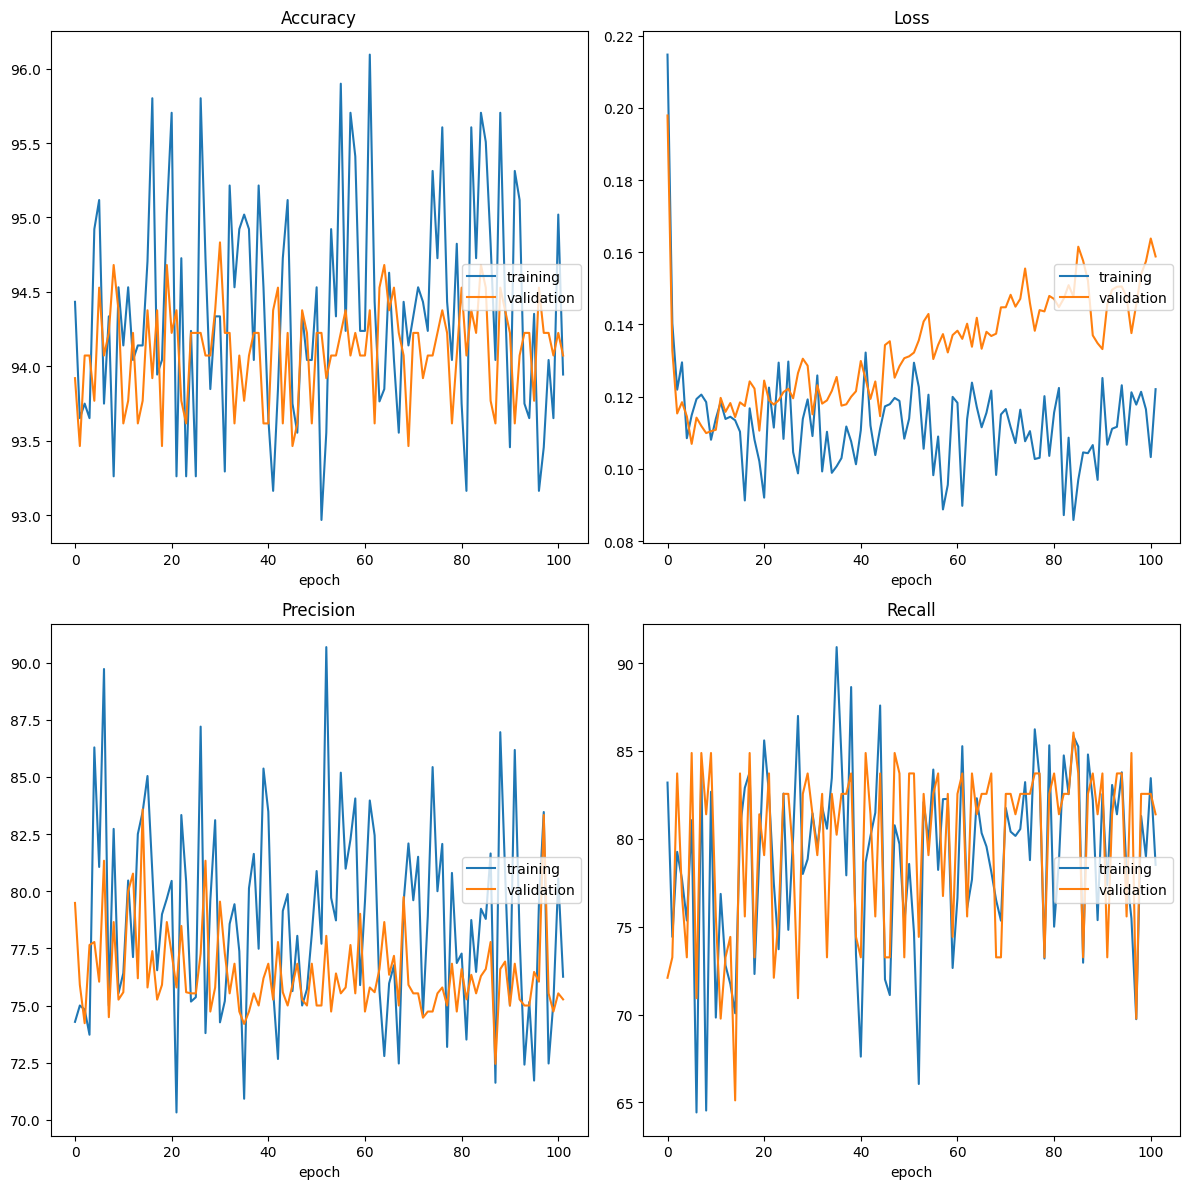

Accuracy
	training         	 (min:   92.969, max:   96.094, cur:   93.945)
	validation       	 (min:   93.465, max:   94.833, cur:   94.073)
Loss
	training         	 (min:    0.086, max:    0.215, cur:    0.122)
	validation       	 (min:    0.107, max:    0.198, cur:    0.159)
Precision
	training         	 (min:   70.323, max:   90.678, cur:   76.259)
	validation       	 (min:   72.449, max:   83.582, cur:   75.269)
Recall
	training         	 (min:   64.430, max:   90.909, cur:   78.519)
	validation       	 (min:   65.116, max:   86.047, cur:   81.395)


In [13]:
while step < 1000:
    for i, batch in enumerate(train_loader):
        x, gt = batch
        x, gt = x.to(device), gt.to(device)

        pred = net(x)
        loss = criterion(pred, gt)
   
        opt.zero_grad()
        loss.backward()
        opt.step()
        step += 1

        # calculating the accuracy
        accuracy = pred.round().eq(gt).float().mean() * 100
        
        # precision
        precision = precision_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy(), zero_division=1) * 100
        
        # recall
        recall = recall_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy()) * 100

        if step % 10 == 0:
          with torch.no_grad():
            for j, test_batch in enumerate(test_loader):
              x, gt = test_batch
              x, gt = x.to(device), gt.to(device)

              pred = net(x)

              test_loss = criterion(pred, gt)

              # calculating the test accuracy
              test_accuracy = pred.round().eq(gt).float().mean() * 100
                
              # test precision
              test_precision = precision_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy(), zero_division=1) * 100
                
              # test recall
              test_recall = recall_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy()) * 100
                
            logs['Loss'] = loss.item()
            logs['val_Loss'] = test_loss.item()
            logs['Accuracy'] = accuracy.item()
            logs['val_Accuracy'] = test_accuracy.item()
            logs['Precision'] = precision
            logs['val_Precision'] = test_precision
            logs['Recall'] = recall
            logs['val_Recall'] = test_recall
            liveloss.update(logs)
            liveloss.send()


TabNet

In [14]:
class Sparsemax(nn.Module):
    def __init__(self, dim=None):
        super(Sparsemax, self).__init__()
        self.dim = -1 if dim is None else dim

    def forward(self, input):
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)
        
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, device=device,step=1, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]
        zs_sparse = is_gt * zs
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)
        self.output = torch.max(torch.zeros_like(input), input - taus)
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)
        return output
    def backward(self, grad_output):
        dim = 1
        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))
        return self.grad_input

In [15]:
# https://towardsdatascience.com/implementing-tabnet-in-pytorch-fc977c383279
# https://www.kaggle.com/code/samratthapa/tabnet-implementation?scriptVersionId=46472520


class GBN(nn.Module):
    def __init__(self,inp,vbs=128,momentum=0.01):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp,momentum=momentum)
        self.vbs = vbs
    def forward(self,x):
        chunk = torch.chunk(x,max(1,x.size(0)//self.vbs),0)
        res = [self.bn(y) for y in chunk ]
        return torch.cat(res,0)

class GLU(nn.Module):
    def __init__(self,inp_dim,out_dim,fc=None,vbs=128):
        super().__init__()
        if fc:
            self.fc = fc
        else:
            self.fc = nn.Linear(inp_dim,out_dim*2)
        self.bn = GBN(out_dim*2,vbs=vbs) 
        self.od = out_dim
    def forward(self,x):
        x = self.bn(self.fc(x))
        return x[:,:self.od]*torch.sigmoid(x[:,self.od:])
    
class FeatureTransformer(nn.Module):
    def __init__(self,inp_dim,out_dim,shared,n_ind,vbs=128):
        super().__init__()
        first = True
        self.shared = nn.ModuleList()
        if shared:
            self.shared.append(GLU(inp_dim,out_dim,shared[0],vbs=vbs))
            first= False    
            for fc in shared[1:]:
                self.shared.append(GLU(out_dim,out_dim,fc,vbs=vbs))
        else:
            self.shared = None
        self.independ = nn.ModuleList()
        if first:
            self.independ.append(GLU(inp,out_dim,vbs=vbs))
        for x in range(first, n_ind):
            self.independ.append(GLU(out_dim,out_dim,vbs=vbs))
        self.scale = torch.sqrt(torch.tensor([.5],device=device))
    def forward(self,x):
        if self.shared:
            x = self.shared[0](x)
            for glu in self.shared[1:]:
                x = torch.add(x, glu(x))
                x = x*self.scale
                
        for glu in self.independ:
            x = torch.add(x, glu(x))
            x = x*self.scale
        return x

class AttentionTransformer(nn.Module):
    def __init__(self,inp_dim,out_dim,relax,vbs=128):
        super().__init__()
        self.fc = nn.Linear(inp_dim,out_dim)
        self.bn = GBN(out_dim,vbs=vbs)
#         self.smax = Sparsemax()
        self.r = torch.tensor([relax],device=device)
    def forward(self,a,priors):
        a = self.bn(self.fc(a))
        mask = torch.sigmoid(a*priors)
        priors =priors*(self.r-mask)
        return mask

class DecisionStep(nn.Module):
    def __init__(self,inp_dim,n_d,n_a,shared,n_ind,relax,vbs=128):
        super().__init__()
        self.fea_tran = FeatureTransformer(inp_dim,n_d+n_a,shared,n_ind,vbs)
        self.atten_tran = AttentionTransformer(n_a,inp_dim,relax,vbs)
    def forward(self,x,a,priors):
        mask = self.atten_tran(a,priors)
        loss = ((-1)*mask*torch.log(mask+1e-10)).mean()
        x = self.fea_tran(x*mask)
        return x,loss
class TabNet(nn.Module):
    def __init__(self, inp_dim, final_out_dim=1, n_d=64, n_a=64, n_shared=2, n_ind=2, n_steps=3, relax=1.2, vbs=128, lambda_sparse=0.0001):
        super().__init__()
        self.lambda_sparse = lambda_sparse  # Adding sparse regularization weight
        
        if n_shared > 0:
            self.shared = nn.ModuleList([nn.Linear(inp_dim, 2 * (n_d + n_a))])
            for _ in range(1, n_shared):
                self.shared.append(nn.Linear(n_d + n_a, 2 * (n_d + n_a)))
        else:
            self.shared = None
        
        self.first_step = FeatureTransformer(inp_dim, n_d + n_a, self.shared, n_ind, vbs=vbs)
        self.steps = nn.ModuleList()
        for _ in range(n_steps - 1):
            self.steps.append(DecisionStep(inp_dim, n_d, n_a, self.shared, n_ind, relax, vbs))
        
        self.fc = nn.Linear(n_d, final_out_dim)
        self.bn = nn.BatchNorm1d(inp_dim)
        self.n_d = n_d
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        x = self.bn(x)
        x_a = self.first_step(x)[:, self.n_d:]
        sparse_loss = torch.tensor(0.).to(self.device)
        out = torch.zeros(x.size(0), self.n_d).to(self.device)
        priors = torch.ones(x.shape).to(self.device)
        for step in self.steps:
            x_te, l = step(x, x_a, priors)
            out += F.relu(x_te[:, :self.n_d])
            x_a = x_te[:, self.n_d:]
            sparse_loss += l
        
        # Final activation function changed to sigmoid for binary classification
        out = torch.sigmoid(self.fc(out))
        # Add the scaled sparse_loss to the main loss outside of this method during optimization
        return out, sparse_loss * self.lambda_sparse
    
class TabNetWithEmbed(nn.Module):
    def __init__(self,inp_dim,final_out_dim,n_d=64,n_a=64,n_shared=2,n_ind=2,n_steps=5,relax=1.2,vbs=128,lambda_sparse=0.00001):
        super().__init__()
        self.tabnet = TabNet(inp_dim,final_out_dim,n_d,n_a,n_shared,n_ind,n_steps,relax,vbs,lambda_sparse)
        self.cat_embed = []
        self.emb1 = nn.Embedding(2,1)
        self.emb3 = nn.Embedding(3,1)
        self.cat_embed.append(self.emb1)
        self.cat_embed.append(self.emb3)
        
    def forward(self,catv,contv):
        catv = catv.to(device)
        contv = contv.to(device)
        embeddings = [embed(catv[:,idx]) for embed,idx in zip(self.cat_embed,range(catv.size(1)))]
        catv = torch.cat(embeddings,1)
        x = torch.cat((catv,contv),1).contiguous()
        x,l = self.tabnet(x)
        return torch.sigmoid(x),l
    
net = TabNet(43, n_d=16, n_a=16, n_shared=2, n_ind=2, n_steps=2, relax=0.8, vbs=128, lambda_sparse=0.00001).to(device)
torch.cuda.empty_cache()
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(net.parameters()))}')

> Number of parameters 15320


In [16]:
opt = torch.optim.Adam(net.parameters(), lr=0.002)

criterion = nn.BCELoss()

In [17]:
step = 0

liveloss = PlotLosses()

# logs for loss plots
logs = {}

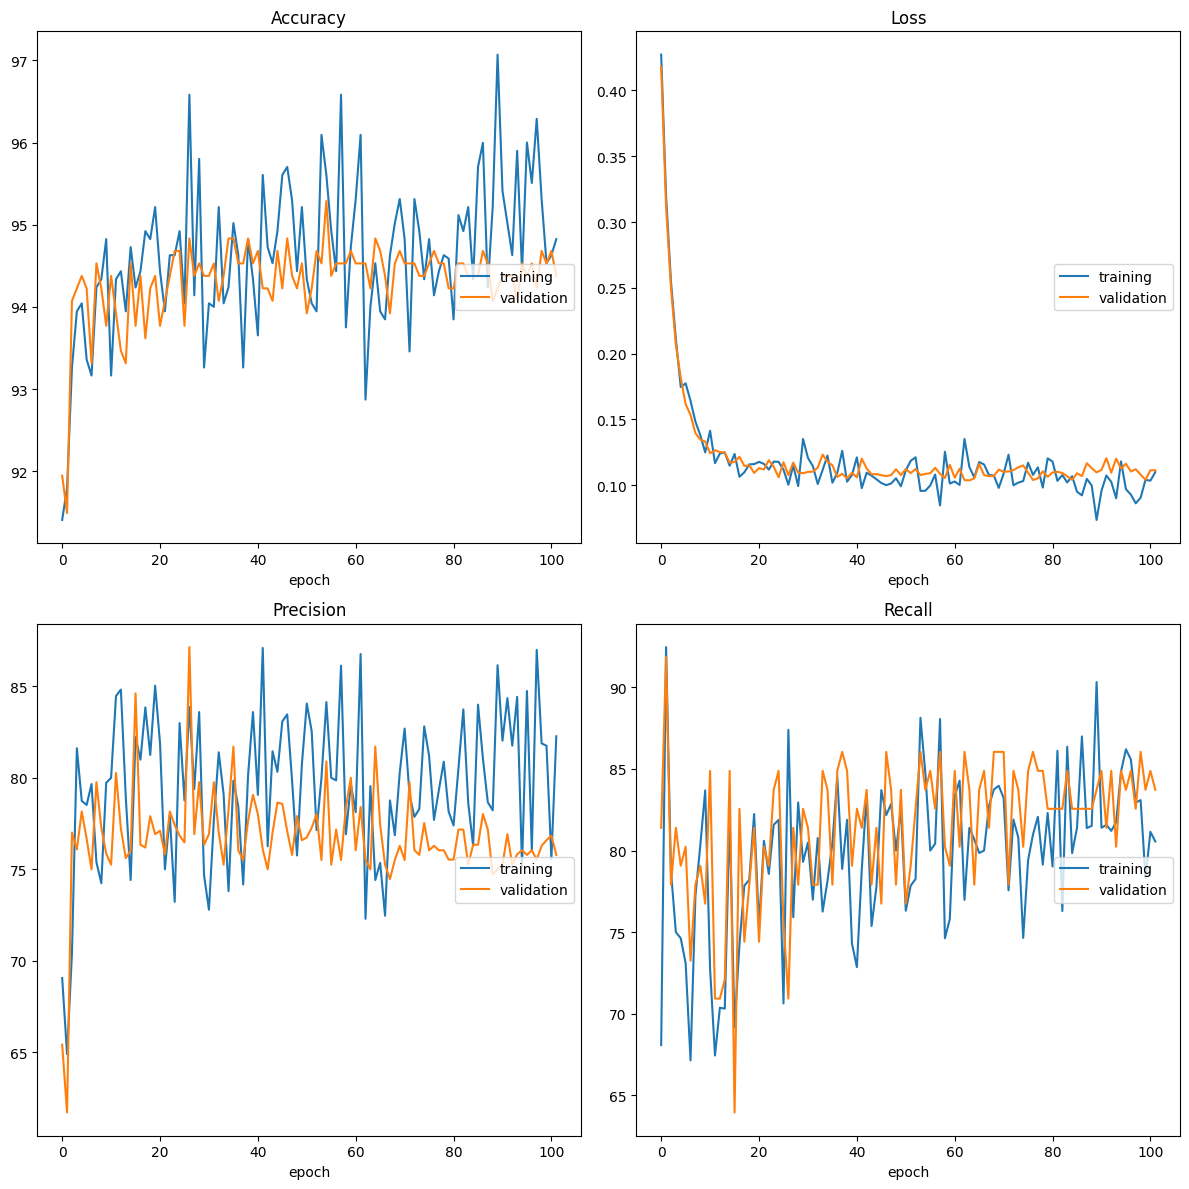

Accuracy
	training         	 (min:   91.406, max:   97.070, cur:   94.824)
	validation       	 (min:   91.489, max:   95.289, cur:   94.377)
Loss
	training         	 (min:    0.074, max:    0.427, cur:    0.110)
	validation       	 (min:    0.104, max:    0.418, cur:    0.111)
Precision
	training         	 (min:   64.904, max:   87.097, cur:   82.270)
	validation       	 (min:   61.719, max:   87.143, cur:   75.789)
Recall
	training         	 (min:   67.143, max:   92.466, cur:   80.556)
	validation       	 (min:   63.953, max:   91.860, cur:   83.721)


In [18]:
while step < 1000:
    for i, batch in enumerate(train_loader):
        x, gt = batch
        x, gt = x.to(device), gt.to(device)

        pred, sparse_loss = net(x)
        loss = criterion(pred, gt) + 1e-4 * sparse_loss
   
        opt.zero_grad()
        loss.backward()
        opt.step()
        step += 1

        # calculating the accuracy
        accuracy = pred.round().eq(gt).float().mean() * 100
        
        # precision
        precision = precision_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy(), zero_division=1) * 100
        
        # recall
        recall = recall_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy()) * 100

        if step % 10 == 0:
          with torch.no_grad():
            for j, test_batch in enumerate(test_loader):
              x, gt = test_batch
              x, gt = x.to(device), gt.to(device)

              pred, sparse_loss = net(x)

              test_loss = criterion(pred, gt) + 1e-4 * sparse_loss

              # calculating the test accuracy
              test_accuracy = pred.round().eq(gt).float().mean() * 100
                
              # test precision
              test_precision = precision_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy(), zero_division=1) * 100
                
              # test recall
              test_recall = recall_score(gt.cpu().detach().numpy(), pred.round().cpu().detach().numpy()) * 100
                
            logs['Loss'] = loss.item()
            logs['val_Loss'] = test_loss.item()
            logs['Accuracy'] = accuracy.item()
            logs['val_Accuracy'] = test_accuracy.item()
            logs['Precision'] = precision
            logs['val_Precision'] = test_precision
            logs['Recall'] = recall
            logs['val_Recall'] = test_recall
            liveloss.update(logs)
            liveloss.send()


CNN

In [33]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.l1 = nn.Conv1d(1, 8, 4,2,1)
        self.b1 = nn.BatchNorm1d(8)
        self.l2 = nn.Conv1d(8, 32, 4,2,1)
        self.b2 = nn.BatchNorm1d(32)
        self.l3 = nn.Conv1d(32, 128, 4,2,1)
        self.b3 = nn.BatchNorm1d(128)
        self.last = nn.Linear(5 * 128, 1)

    def forward(self, x):
        x = torch.relu(self.b1(self.l1(x)))
        x = torch.relu(self.b2(self.l2(x)))
        x = torch.relu(self.b3(self.l3(x)))
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.last(x))
    
conv = Conv().to(device)
conv
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(conv.parameters()))}')

> Number of parameters 18585


In [34]:
conv_opt = torch.optim.Adam(conv.parameters(), lr=0.03402934428936064)

criterion = nn.BCELoss()

In [35]:
step = 0

liveloss = PlotLosses()

# logs for loss plots
logs = {}

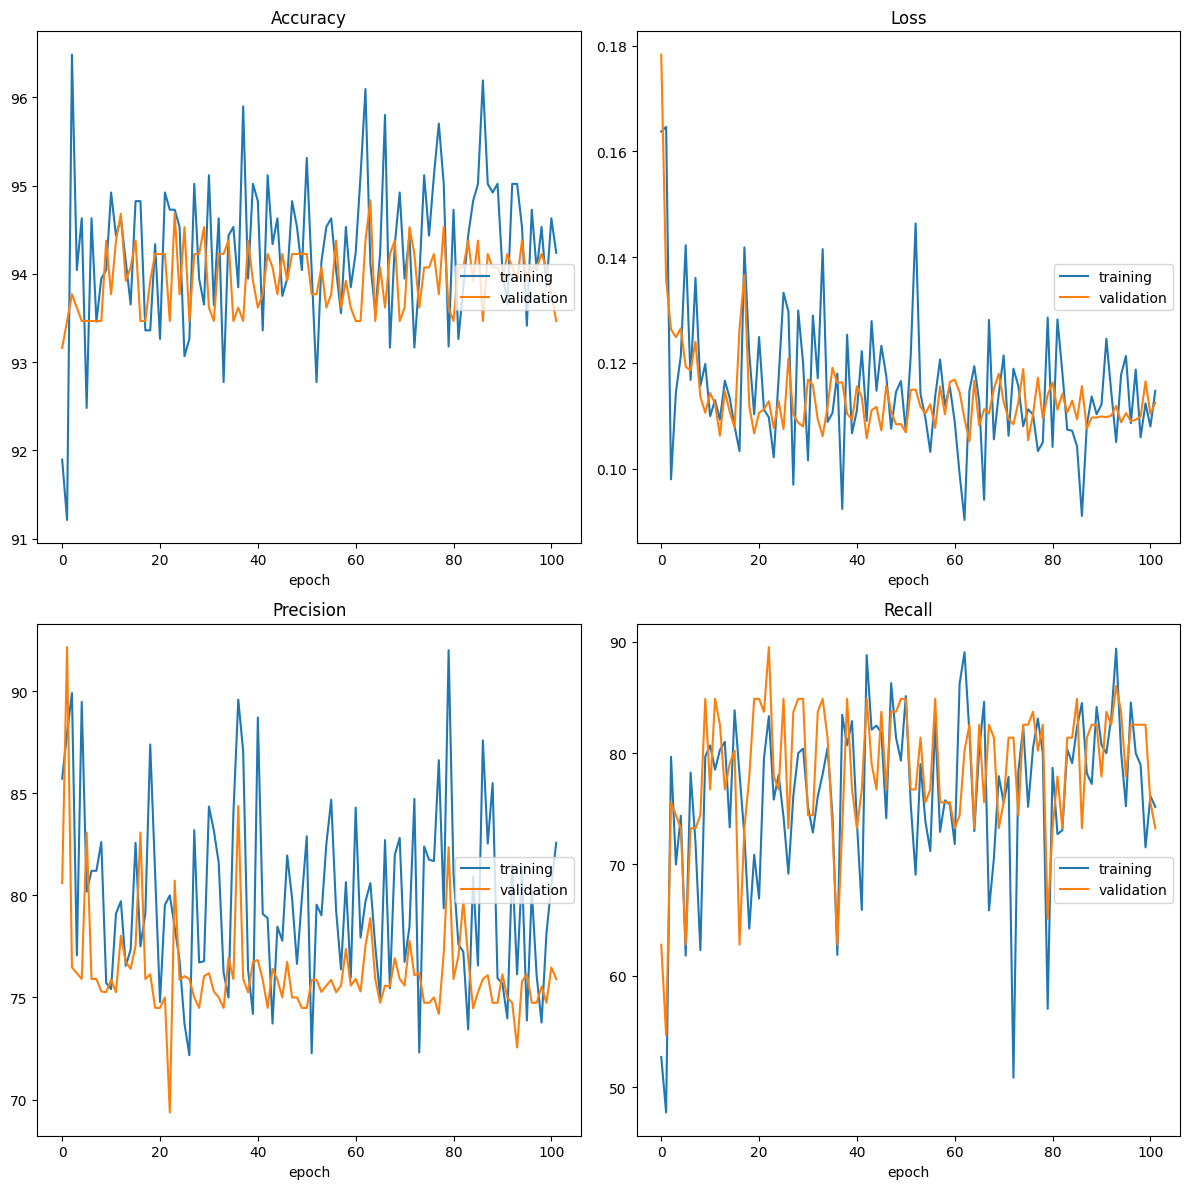

Accuracy
	training         	 (min:   91.211, max:   96.484, cur:   94.238)
	validation       	 (min:   93.161, max:   94.833, cur:   93.465)
Loss
	training         	 (min:    0.090, max:    0.165, cur:    0.115)
	validation       	 (min:    0.105, max:    0.178, cur:    0.112)
Precision
	training         	 (min:   72.174, max:   92.000, cur:   82.576)
	validation       	 (min:   69.369, max:   92.157, cur:   75.904)
Recall
	training         	 (min:   47.712, max:   89.394, cur:   75.172)
	validation       	 (min:   54.651, max:   89.535, cur:   73.256)


In [36]:
# outer loop - going over the steps we want to train for
while step < 1000:
  # inner loop - iterating over the batches
  for i, batch in enumerate(train_loader):

    # getting the input and the ground truth labels from the training set
    x, gt = batch
    x = x.unsqueeze(1)
    x, gt = x.to(device), gt.to(device)

    # forward pass
    output = conv(x)

    # loss
    loss = criterion(output, gt)

    # explicitly set the gradients to zero before backpropagation
    conv.zero_grad()

    # backward pass
    loss.backward()
    conv_opt.step()
    step += 1

    # calculating the accuracy
    accuracy = output.round().eq(gt).float().mean() * 100
    
    # precision
    precision = precision_score(gt.cpu().detach().numpy(), output.round().cpu().detach().numpy(), zero_division=1) * 100
        
    # recall
    recall = recall_score(gt.cpu().detach().numpy(), output.round().cpu().detach().numpy()) * 100
    
    # every 10 steps we evaluate the model on the test set
    if step % 10 == 0:

      # when we test, we don't need gradients
      with torch.no_grad():

        # beginning the loop for evaluation:
        for j, test_batch in enumerate(test_loader):

          # getting the input and the ground truth labels from the training set
          x, gt = test_batch
          x = x.unsqueeze(1)
          x, gt = x.to(device), gt.to(device)

          # forward pass
          output = conv(x)

          # test loss
          test_loss = criterion(output, gt)

          # calculating the test accuracy
          test_accuracy = output.round().eq(gt).float().mean() * 100
        
          # test precision
          test_precision = precision_score(gt.cpu().detach().numpy(), output.round().cpu().detach().numpy(), zero_division=1) * 100
                
          # test recall
          test_recall = recall_score(gt.cpu().detach().numpy(), output.round().cpu().detach().numpy()) * 100

        # logging train and test losses and accuracies
        logs['Loss'] = loss.item()
        logs['val_Loss'] = test_loss.item()
        logs['Accuracy'] = accuracy.item()
        logs['val_Accuracy'] = test_accuracy.item()
        logs['Precision'] = precision
        logs['val_Precision'] = test_precision
        logs['Recall'] = recall
        logs['val_Recall'] = test_recall
        liveloss.update(logs)
        liveloss.send()

### Multiclass Classification

In [37]:
y = df.filter(items=['type'])
y['type'].nunique()

10

In [38]:
label_encoder = LabelEncoder()

y_int = label_encoder.fit_transform(y)

/home2/tghv73/myjupyterenv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
for i, label in enumerate(label_encoder.classes_):
    print(f"Original label: '{label}' is mapped to: {i}")

Original label: 'backdoor' is mapped to: 0
Original label: 'ddos' is mapped to: 1
Original label: 'dos' is mapped to: 2
Original label: 'injection' is mapped to: 3
Original label: 'mitm' is mapped to: 4
Original label: 'normal' is mapped to: 5
Original label: 'password' is mapped to: 6
Original label: 'ransomware' is mapped to: 7
Original label: 'scanning' is mapped to: 8
Original label: 'xss' is mapped to: 9


In [40]:
x = torch.Tensor(X.values) 
gt = torch.Tensor(y_int).long()

In [41]:
gt.size()

torch.Size([46564])

In [42]:
x.size()

torch.Size([46564, 43])

In [43]:
# Create a TensorDataset from your data and labels
dataset = TensorDataset(x, gt)

# Calculate the number of samples for training and testing datasets
num_samples = len(dataset)
train_size = int(num_samples * 0.7)
test_size = num_samples - train_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

MLP

In [44]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(43, 128)
        self.b1 = nn.BatchNorm1d(128)
        self.l2 = nn.Linear(128, 16)
        self.b2 = nn.BatchNorm1d(16)
        self.l3 = nn.Linear(16, 64)
        self.b3 = nn.BatchNorm1d(64)
        self.last = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.b1(self.l1(x)))
        x = torch.relu(self.b2(self.l2(x)))
        x = torch.relu(self.b3(self.l3(x)))
        return torch.softmax(self.last(x), dim=1)
    
net = MLP().to(device)
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(net.parameters()))}')

> Number of parameters 9850


In [45]:
opt = torch.optim.Adam(net.parameters(), lr=0.008430868939509882)

criterion = nn.CrossEntropyLoss()

In [46]:
step = 0

liveloss = PlotLosses()

# logs for loss plots
logs = {}

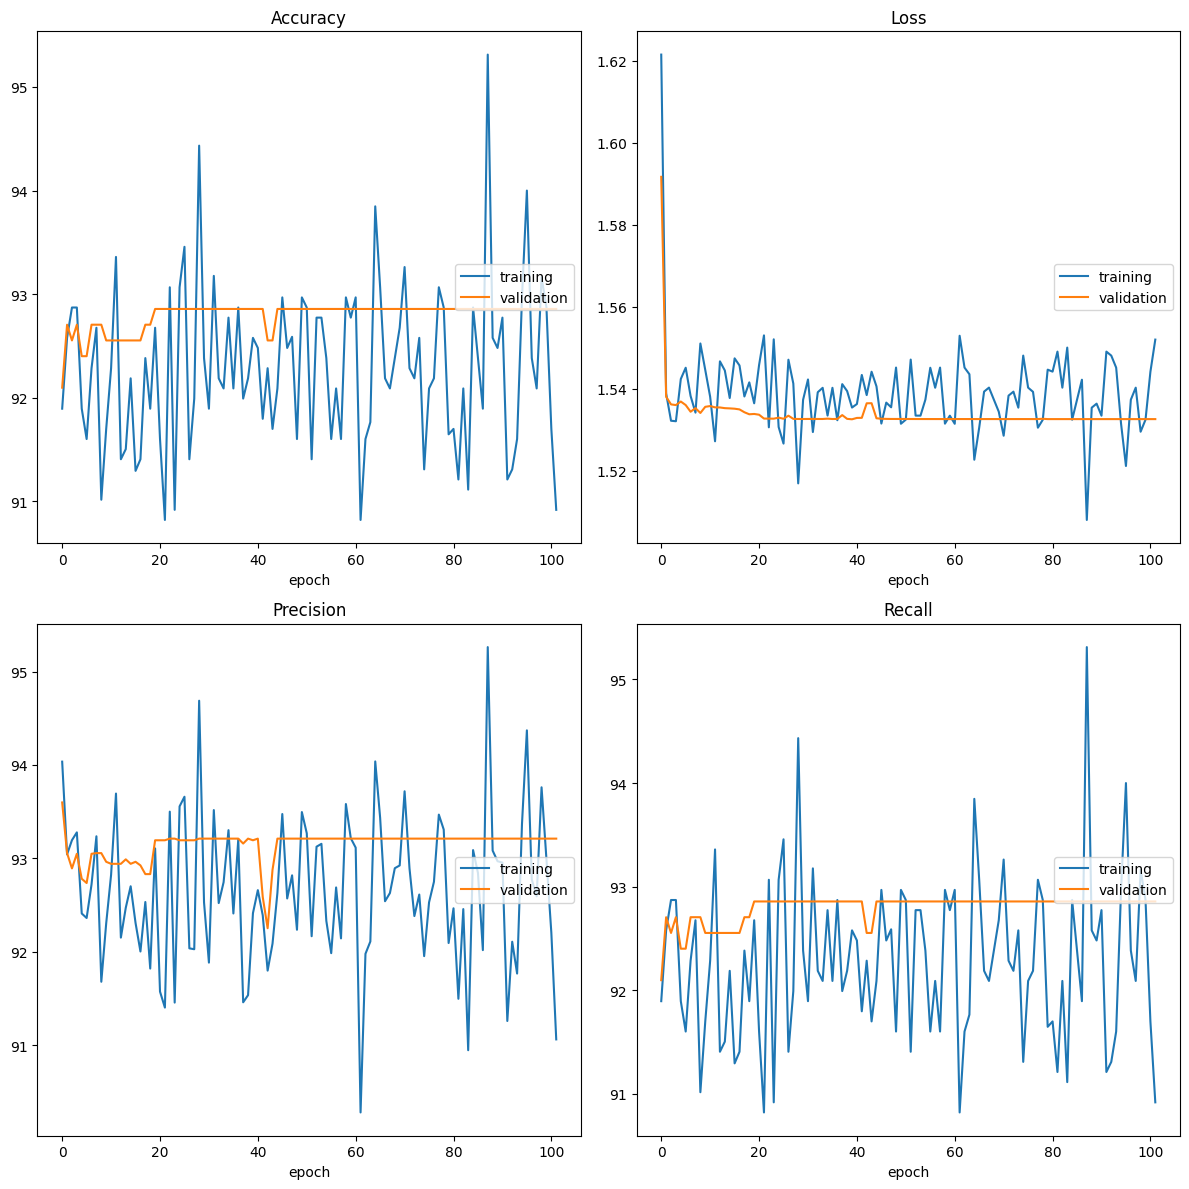

Accuracy
	training         	 (min:   90.820, max:   95.312, cur:   90.918)
	validation       	 (min:   92.097, max:   92.857, cur:   92.857)
Loss
	training         	 (min:    1.508, max:    1.621, cur:    1.552)
	validation       	 (min:    1.533, max:    1.592, cur:    1.533)
Precision
	training         	 (min:   90.279, max:   95.262, cur:   91.062)
	validation       	 (min:   92.252, max:   93.598, cur:   93.211)
Recall
	training         	 (min:   90.820, max:   95.312, cur:   90.918)
	validation       	 (min:   92.097, max:   92.857, cur:   92.857)


In [47]:
while step < 1000:
    for i, batch in enumerate(train_loader):
        x, gt = batch
        x, gt = x.to(device), gt.to(device)

        pred = net(x)
        loss = criterion(pred, gt)
   
        opt.zero_grad()
        loss.backward()
        opt.step()
        step += 1

        # calculating the accuracy
        _, argmax = torch.max(pred, dim=1)
        accuracy = argmax.eq(gt).float().mean() * 100
        
        # precision
        precision = precision_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(), average='weighted', zero_division=1) * 100
        
        # recall
        recall = recall_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(),average='weighted') * 100

        if step % 10 == 0:
          with torch.no_grad():
            for j, test_batch in enumerate(test_loader):
              x, gt = test_batch
              x, gt = x.to(device), gt.to(device)

              pred = net(x)

              test_loss = criterion(pred, gt)

              # calculating the test accuracy
              _, argmax = torch.max(pred, dim=1)
              test_accuracy = argmax.eq(gt).float().mean() * 100
                
              # test precision
              test_precision = precision_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(),average='weighted', zero_division=1) * 100
                
              # test recall
              test_recall = recall_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(), average='weighted') * 100
                
            logs['Loss'] = loss.item()
            logs['val_Loss'] = test_loss.item()
            logs['Accuracy'] = accuracy.item()
            logs['val_Accuracy'] = test_accuracy.item()
            logs['Precision'] = precision
            logs['val_Precision'] = test_precision
            logs['Recall'] = recall
            logs['val_Recall'] = test_recall
            liveloss.update(logs)
            liveloss.send()


In [48]:
def evaluate(attack_label, attack, lst):
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            # Filter to include only the instances of the subset
            mask = labels == attack_label
            subset_predicted = predicted[mask]
            subset_labels = labels[mask]

            total += subset_labels.size(0)
            correct += (subset_predicted == subset_labels).sum().item()

    # Calculate accuracy for the subset
    if total > 0:
        accuracy = correct / total
        print(f"Accuracy for classifying the {attack} attacks: {accuracy * 100:.2f}%")
        lst.append(round(accuracy * 100, 2))
    else:
        print("No instances of the subset were found in the test set.")

In [49]:
attack_accuracy = []
attack_lst = []
for i, label in enumerate(label_encoder.classes_):
    attack_lst.append(label)
    evaluate(i, label, attack_accuracy)

Accuracy for classifying the backdoor attacks: 0.00%
Accuracy for classifying the ddos attacks: 24.89%
Accuracy for classifying the dos attacks: 34.08%
Accuracy for classifying the injection attacks: 0.00%
Accuracy for classifying the mitm attacks: 0.00%
Accuracy for classifying the normal attacks: 98.95%
Accuracy for classifying the password attacks: 0.00%
Accuracy for classifying the ransomware attacks: 0.00%
Accuracy for classifying the scanning attacks: 0.00%
Accuracy for classifying the xss attacks: 82.32%


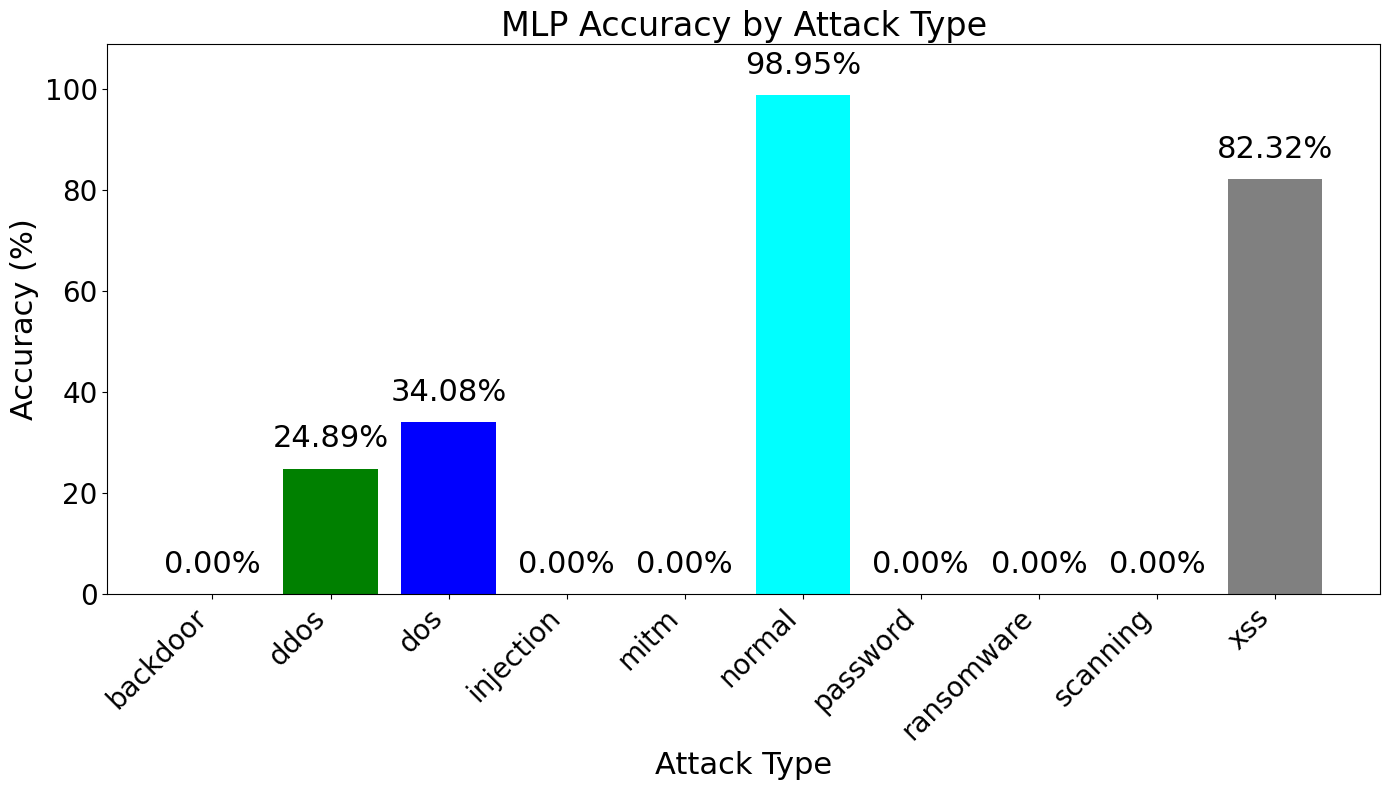

In [16]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'gray']

attack_accuracy = [0, 24.89, 34.08, 0, 0, 98.95, 0, 0, 0, 82.32]
attack_lst = ["backdoor", "ddos", "dos", "injection", "mitm", "normal", "password", "ransomware", "scanning", "xss"]

plt.figure(figsize=(14, 8))
bars = plt.bar(attack_lst, attack_accuracy, color=colors)

plt.xlabel('Attack Type', fontsize=22)
plt.ylabel('Accuracy (%)', fontsize=22)
plt.title('MLP Accuracy by Attack Type', fontsize=24)
plt.ylim(0, max(attack_accuracy) + 10) 

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, f"{yval:.2f}%", ha='center', va='bottom', fontsize=22)
    
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

TabNet

In [51]:
class TabNetWithEmbed(nn.Module):
    def __init__(self,inp_dim,final_out_dim,n_d=64,n_a=64,n_shared=2,n_ind=2,n_steps=5,relax=1.2,vbs=128):
        super().__init__()
        self.tabnet = TabNet(inp_dim,final_out_dim,n_d,n_a,n_shared,n_ind,n_steps,relax,vbs)
        self.cat_embed = []
        self.emb1 = nn.Embedding(2,1)
        self.emb3 = nn.Embedding(3,1)
        self.cat_embed.append(self.emb1)
        self.cat_embed.append(self.emb3)
        
    def forward(self,catv,contv):
        catv = catv.to(device)
        contv = contv.to(device)
        embeddings = [embed(catv[:,idx]) for embed,idx in zip(self.cat_embed,range(catv.size(1)))]
        catv = torch.cat(embeddings,1)
        x = torch.cat((catv,contv),1).contiguous()
        x,l = self.tabnet(x)
        return torch.softmax(x, dim=1),l
    
net = TabNet(43, 10, n_d=16, n_a=16, n_shared=2, n_ind=2, n_steps=2, relax=0.8, vbs=128, lambda_sparse=0.00001).to(device)
torch.cuda.empty_cache()
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(net.parameters()))}')

> Number of parameters 15473


In [53]:
opt = torch.optim.Adam(net.parameters(), lr=0.002)

criterion = nn.CrossEntropyLoss()

In [54]:
step = 0

liveloss = PlotLosses()

# logs for loss plots
logs = {}

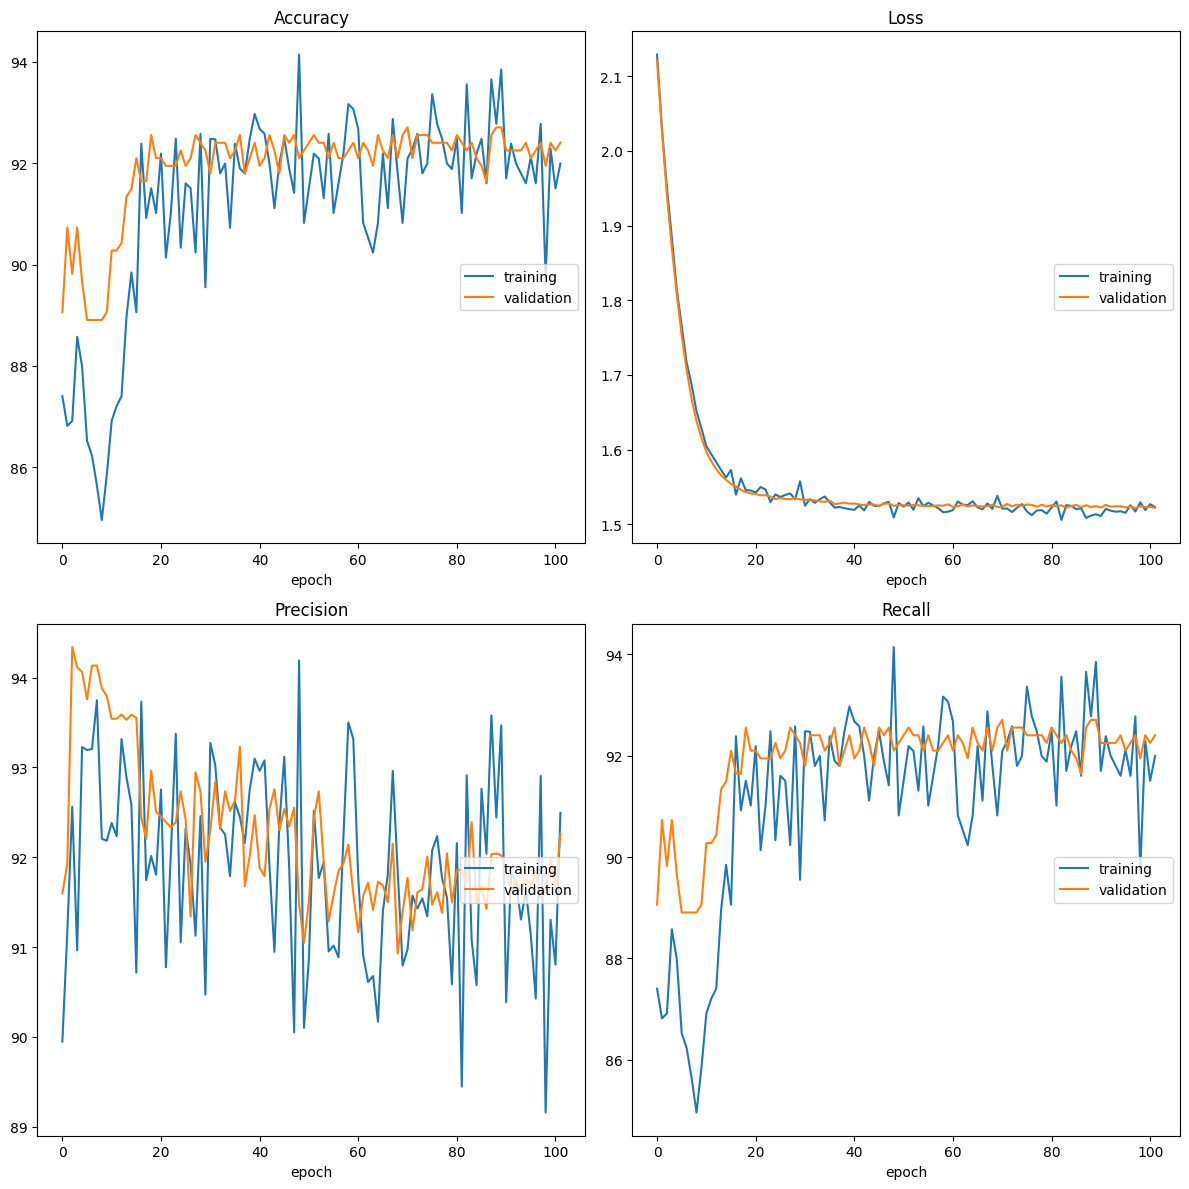

Accuracy
	training         	 (min:   84.961, max:   94.141, cur:   91.992)
	validation       	 (min:   88.906, max:   92.705, cur:   92.401)
Loss
	training         	 (min:    1.506, max:    2.129, cur:    1.523)
	validation       	 (min:    1.522, max:    2.120, cur:    1.522)
Precision
	training         	 (min:   89.160, max:   94.191, cur:   92.495)
	validation       	 (min:   90.928, max:   94.339, cur:   92.259)
Recall
	training         	 (min:   84.961, max:   94.141, cur:   91.992)
	validation       	 (min:   88.906, max:   92.705, cur:   92.401)


In [55]:
while step < 1000:
    for i, batch in enumerate(train_loader):
        x, gt = batch
        x, gt = x.to(device), gt.to(device)

        pred, sparse_loss = net(x)
        loss = criterion(pred, gt) + 1e-4 * sparse_loss
   
        opt.zero_grad()
        loss.backward()
        opt.step()
        step += 1

        # calculating the accuracy
        _, argmax = torch.max(pred, dim=1)
        accuracy = argmax.eq(gt).float().mean() * 100
        
        # precision
        precision = precision_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(), average='weighted', zero_division=1) * 100
        
        # recall
        recall = recall_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(),average='weighted') * 100

        if step % 10 == 0:
          with torch.no_grad():
            for j, test_batch in enumerate(test_loader):
              x, gt = test_batch
              x, gt = x.to(device), gt.to(device)

              pred, sparse_loss = net(x)

              test_loss = criterion(pred, gt) + 1e-4 * sparse_loss

              # calculating the test accuracy
              _, argmax = torch.max(pred, dim=1)
              test_accuracy = argmax.eq(gt).float().mean() * 100
                
              # test precision
              test_precision = precision_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(),average='weighted', zero_division=1) * 100
                
              # test recall
              test_recall = recall_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(), average='weighted') * 100
                
            logs['Loss'] = loss.item()
            logs['val_Loss'] = test_loss.item()
            logs['Accuracy'] = accuracy.item()
            logs['val_Accuracy'] = test_accuracy.item()
            logs['Precision'] = precision
            logs['val_Precision'] = test_precision
            logs['Recall'] = recall
            logs['val_Recall'] = test_recall
            liveloss.update(logs)
            liveloss.send()


In [56]:
def evaluate(attack_label, attack, lst):
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, loss = net(inputs)
            _, predicted = torch.max(outputs, 1)

            # Filter to include only the instances of the subset
            mask = labels == attack_label
            subset_predicted = predicted[mask]
            subset_labels = labels[mask]

            total += subset_labels.size(0)
            correct += (subset_predicted == subset_labels).sum().item()

    # Calculate accuracy for the subset
    if total > 0:
        accuracy = correct / total
        print(f"Accuracy for classifying the {attack} attacks: {accuracy * 100:.2f}%")
        lst.append(round(accuracy * 100, 2))
    else:
        print("No instances of the subset were found in the test set.")

In [57]:
attack_accuracy = []
attack_lst = []
for i, label in enumerate(label_encoder.classes_):
    attack_lst.append(label)
    evaluate(i, label, attack_accuracy)

Accuracy for classifying the backdoor attacks: 0.00%
Accuracy for classifying the ddos attacks: 32.44%
Accuracy for classifying the dos attacks: 0.00%
Accuracy for classifying the injection attacks: 22.90%
Accuracy for classifying the mitm attacks: 0.00%
Accuracy for classifying the normal attacks: 98.94%
Accuracy for classifying the password attacks: 0.00%
Accuracy for classifying the ransomware attacks: 0.00%
Accuracy for classifying the scanning attacks: 0.00%
Accuracy for classifying the xss attacks: 73.05%


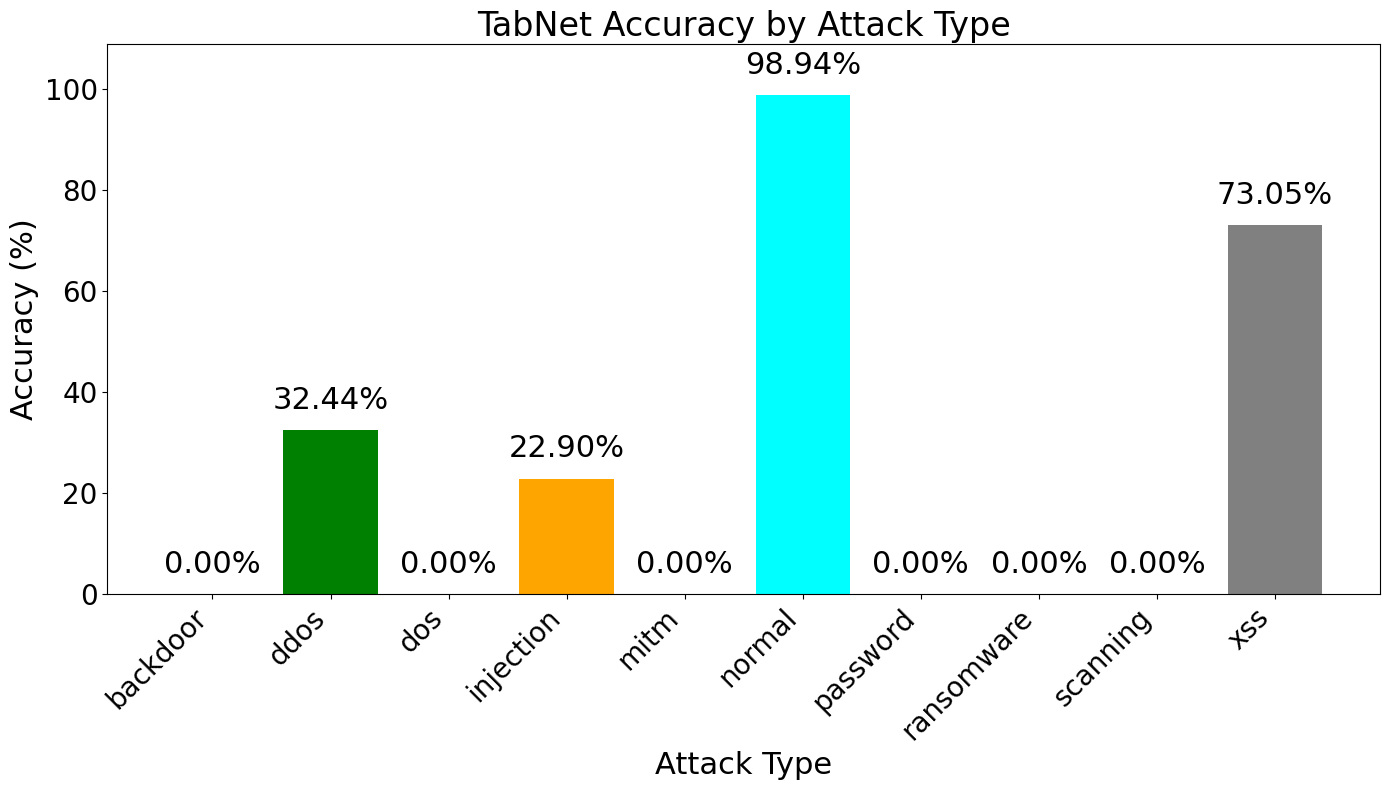

In [17]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'gray']
attack_accuracy = [0, 32.44, 0, 22.90, 0, 98.94, 0, 0, 0, 73.05]

plt.figure(figsize=(14, 8))
bars = plt.bar(attack_lst, attack_accuracy, color=colors)
    
plt.xlabel('Attack Type', fontsize=22)
plt.ylabel('Accuracy (%)', fontsize=22)
plt.title('TabNet Accuracy by Attack Type', fontsize=24)
plt.ylim(0, max(attack_accuracy) + 10) 

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, f"{yval:.2f}%", ha='center', va='bottom', fontsize=22)
    
plt.xticks(rotation=45, ha='right',fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

CNN

In [59]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.l1 = nn.Conv1d(1, 8, 4,2,1)
        self.b1 = nn.BatchNorm1d(8)
        self.l2 = nn.Conv1d(8, 32, 4,2,1)
        self.b2 = nn.BatchNorm1d(32)
        self.l3 = nn.Conv1d(32, 128, 4,2,1)
        self.b3 = nn.BatchNorm1d(128)
        self.last = nn.Linear(5 * 128, 10)

    def forward(self, x):
        x = torch.relu(self.b1(self.l1(x)))
        x = torch.relu(self.b2(self.l2(x)))
        x = torch.relu(self.b3(self.l3(x)))
        x = x.view(x.size(0), -1)
        return torch.log_softmax(self.last(x), dim=1)
    
conv = Conv().to(device)
conv
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(conv.parameters()))}')

> Number of parameters 24354


In [60]:
conv_opt = torch.optim.Adam(conv.parameters(), lr=0.03402934428936064)

criterion = nn.CrossEntropyLoss()

In [61]:
step = 0

liveloss = PlotLosses()

# logs for loss plots
logs = {}

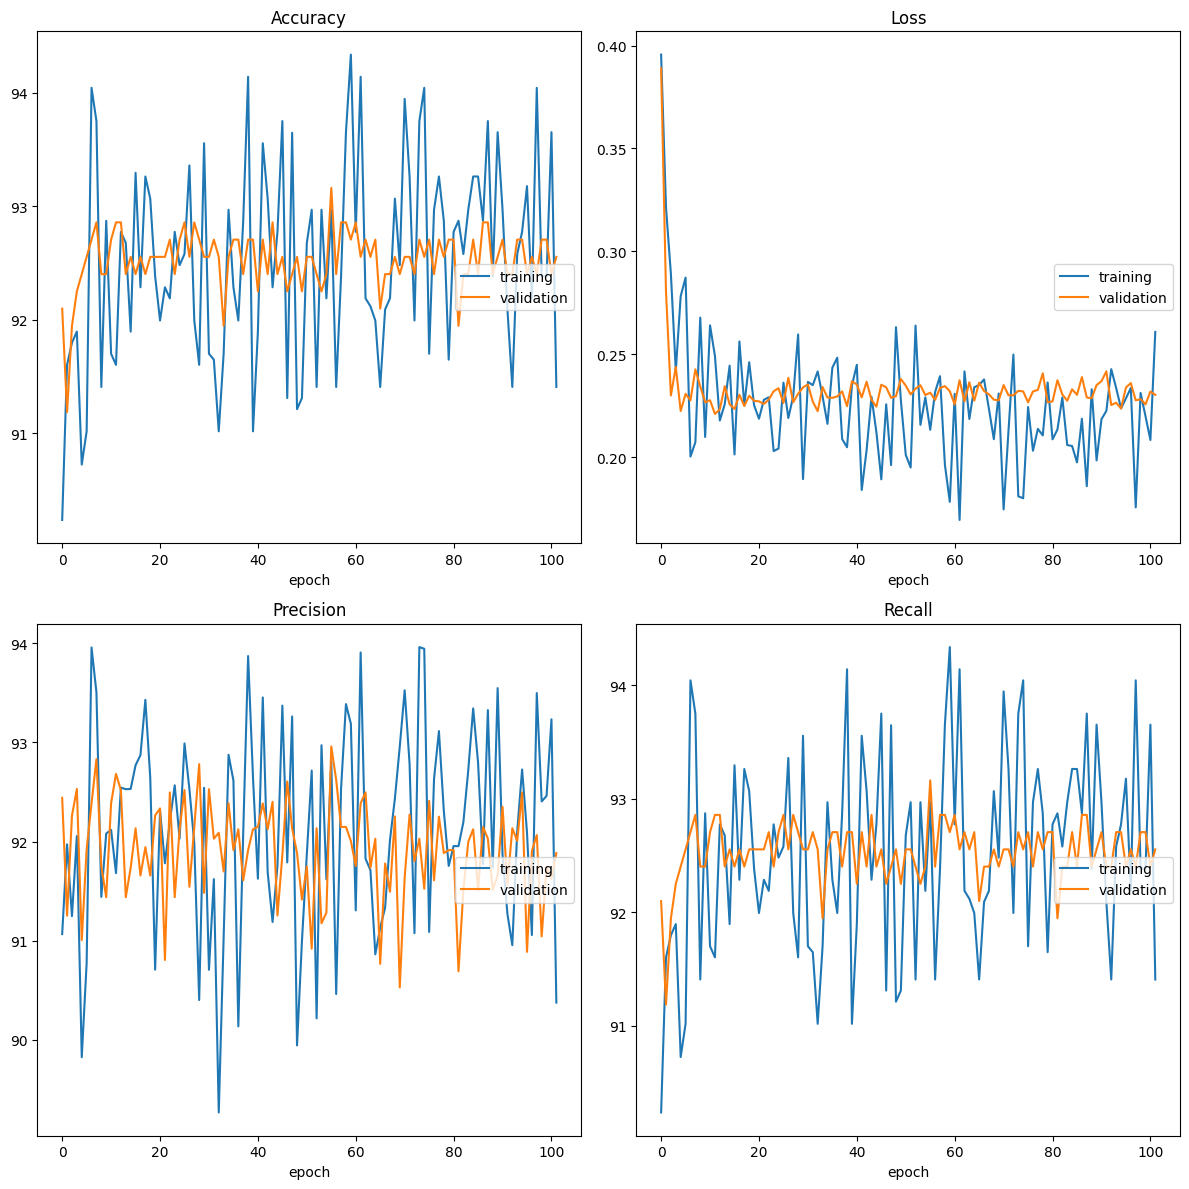

Accuracy
	training         	 (min:   90.234, max:   94.336, cur:   91.406)
	validation       	 (min:   91.185, max:   93.161, cur:   92.553)
Loss
	training         	 (min:    0.170, max:    0.396, cur:    0.261)
	validation       	 (min:    0.221, max:    0.389, cur:    0.230)
Precision
	training         	 (min:   89.269, max:   93.962, cur:   90.377)
	validation       	 (min:   90.530, max:   92.960, cur:   91.885)
Recall
	training         	 (min:   90.234, max:   94.336, cur:   91.406)
	validation       	 (min:   91.185, max:   93.161, cur:   92.553)


In [62]:
# outer loop - going over the steps we want to train for
while step < 1000:
  # inner loop - iterating over the batches
  for i, batch in enumerate(train_loader):

    # getting the input and the ground truth labels from the training set
    x, gt = batch
    x = x.unsqueeze(1)
    x, gt = x.to(device), gt.to(device)

    # forward pass
    output = conv(x)

    # loss
    loss = criterion(output, gt)

    # explicitly set the gradients to zero before backpropagation
    conv.zero_grad()

    # backward pass
    loss.backward()
    conv_opt.step()
    step += 1

    # calculating the accuracy
    _, argmax = torch.max(output, dim=1)
    accuracy = argmax.eq(gt).float().mean() * 100
    
    # precision
    precision = precision_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(), average='weighted', zero_division=1) * 100

    # recall
    recall = recall_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(),average='weighted') * 100
    
    # every 10 steps we evaluate the model on the test set
    if step % 10 == 0:

      # when we test, we don't need gradients
      with torch.no_grad():

        # beginning the loop for evaluation:
        for j, test_batch in enumerate(test_loader):

          # getting the input and the ground truth labels from the training set
          x, gt = test_batch
          x = x.unsqueeze(1)
          x, gt = x.to(device), gt.to(device)

          # forward pass
          output = conv(x)

          # test loss
          test_loss = criterion(output, gt)

           # calculating the test accuracy
          _, argmax = torch.max(output, dim=1)
          test_accuracy = argmax.eq(gt).float().mean() * 100

          # test precision
          test_precision = precision_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(),average='weighted', zero_division=1) * 100

          # test recall
          test_recall = recall_score(gt.cpu().detach().numpy(), argmax.cpu().detach().numpy(), average='weighted') * 100

        # logging train and test losses and accuracies
        logs['Loss'] = loss.item()
        logs['val_Loss'] = test_loss.item()
        logs['Accuracy'] = accuracy.item()
        logs['val_Accuracy'] = test_accuracy.item()
        logs['Precision'] = precision
        logs['val_Precision'] = test_precision
        logs['Recall'] = recall
        logs['val_Recall'] = test_recall
        liveloss.update(logs)
        liveloss.send()

In [63]:
def evaluate(attack_label, attack, lst):
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = conv(inputs)
            _, predicted = torch.max(outputs, 1)

            # Filter to include only the instances of the subset
            mask = labels == attack_label
            subset_predicted = predicted[mask]
            subset_labels = labels[mask]

            total += subset_labels.size(0)
            correct += (subset_predicted == subset_labels).sum().item()

    # Calculate accuracy for the subset
    if total > 0:
        accuracy = correct / total
        print(f"Accuracy for classifying the {attack} attacks: {accuracy * 100:.2f}%")
        lst.append(round(accuracy * 100, 2))
    else:
        print("No instances of the subset were found in the test set.")

In [64]:
attack_accuracy = []
attack_lst = []
for i, label in enumerate(label_encoder.classes_):
    attack_lst.append(label)
    evaluate(i, label, attack_accuracy)

Accuracy for classifying the backdoor attacks: 37.50%
Accuracy for classifying the ddos attacks: 37.33%
Accuracy for classifying the dos attacks: 35.20%
Accuracy for classifying the injection attacks: 6.54%
Accuracy for classifying the mitm attacks: 0.00%
Accuracy for classifying the normal attacks: 98.69%
Accuracy for classifying the password attacks: 3.23%
Accuracy for classifying the ransomware attacks: 0.00%
Accuracy for classifying the scanning attacks: 0.00%
Accuracy for classifying the xss attacks: 82.21%


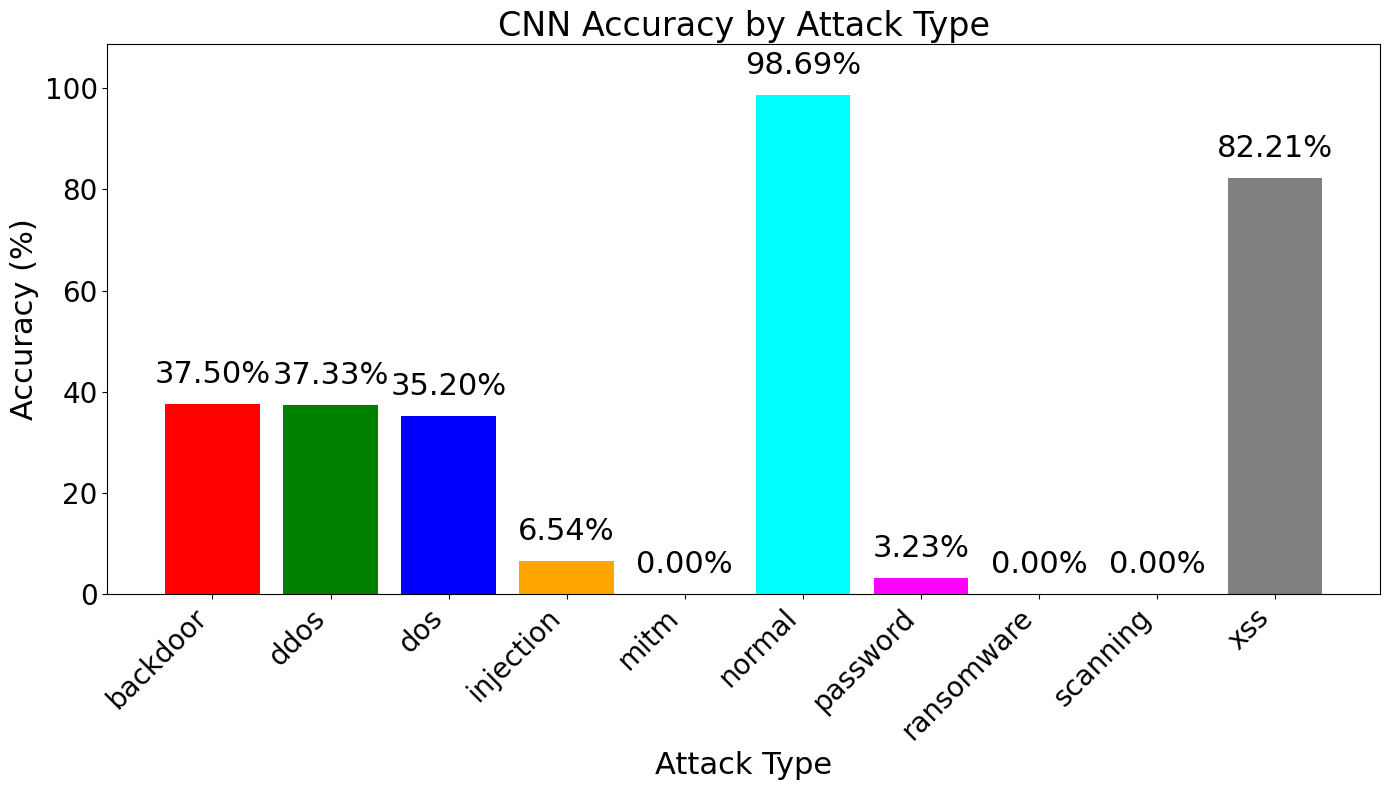

In [18]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'gray']
attack_accuracy = [37.50, 37.33, 35.20, 6.54, 0, 98.69, 3.23, 0, 0, 82.21]

plt.figure(figsize=(14, 8))
bars = plt.bar(attack_lst, attack_accuracy, color=colors)

plt.xlabel('Attack Type', fontsize=22)
plt.ylabel('Accuracy (%)', fontsize=22)
plt.title('CNN Accuracy by Attack Type', fontsize=24)
plt.ylim(0, max(attack_accuracy) + 10) 

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, f"{yval:.2f}%", ha='center', va='bottom', fontsize=22)
    
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()